In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import Image

import os, sys, re, datetime, time, copy
from pathlib import Path

from matplotlib import pyplot as plt
import japanize_matplotlib
import seaborn as sns
plt.style.use("bmh")
import numpy as np
import pandas as pd
import dask.dataframe as dd

from tqdm import tqdm_notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms

In [20]:
data_dir = Path(os.getcwd()).parents[1]/'data/hymenoptera_data'

In [6]:
model_name = "vgg"
num_classes = 2
batch_size = 8
num_epochs = 15
feature_extract = True # if False, we train whole params

In [33]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, device='cpu'):
    since = time.time()
    
    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # set model to training mode
            else: 
                model.eval()  # set model to evaluating mode
                
            running_loss = 0.
            running_corrects = 0.
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                # forward
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds==labels.data)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                
        print()
        
    time_elapsed = time.time() - since
    
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    
    return model, val_acc_history

In [13]:
def set_parameter_requires_grad(model, feature_extract):
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False

In [14]:
# https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#inception-v3
use_pretrained=True
model_ft = models.vgg11_bn(pretrained=use_pretrained)
set_parameter_requires_grad(model_ft, feature_extract)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
input_size = 224

In [18]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [22]:
image_datasets = {x: datasets.ImageFolder(data_dir/x, data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}


In [25]:
device = 'cpu'

In [26]:
model_ft = model_ft.to(device)

In [30]:
params_to_update = model_ft.parameters()
print("Params to learn:")
params_to_update = []
for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [34]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 0.4688 Acc: 0.7418
val Loss: 0.1841 Acc: 0.9281

Epoch 1/14
----------
train Loss: 0.3340 Acc: 0.8566
val Loss: 0.2050 Acc: 0.8889

Epoch 2/14
----------
train Loss: 0.2590 Acc: 0.8811
val Loss: 0.1516 Acc: 0.9412

Epoch 3/14
----------
train Loss: 0.2170 Acc: 0.9221
val Loss: 0.1417 Acc: 0.9477

Epoch 4/14
----------
train Loss: 0.2459 Acc: 0.9057
val Loss: 0.1451 Acc: 0.9477

Epoch 5/14
----------
train Loss: 0.2591 Acc: 0.9016
val Loss: 0.1572 Acc: 0.9412

Epoch 6/14
----------
train Loss: 0.2080 Acc: 0.8975
val Loss: 0.1698 Acc: 0.9281

Epoch 7/14
----------
train Loss: 0.1845 Acc: 0.9180
val Loss: 0.1643 Acc: 0.9281

Epoch 8/14
----------
train Loss: 0.1819 Acc: 0.9221
val Loss: 0.1478 Acc: 0.9346

Epoch 9/14
----------
train Loss: 0.1847 Acc: 0.9262
val Loss: 0.1527 Acc: 0.9346

Epoch 10/14
----------
train Loss: 0.1894 Acc: 0.9303
val Loss: 0.1450 Acc: 0.9346

Epoch 11/14
----------
train Loss: 0.2480 Acc: 0.9016
val Loss: 0.1519 Acc: 0.9346

Ep

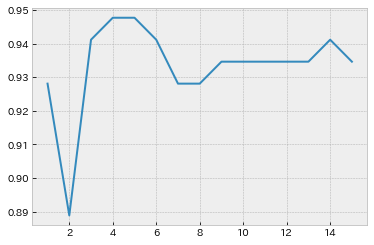

In [35]:
ohist = [h.cpu().numpy() for h in hist]
plt.plot(range(1,num_epochs+1), ohist, label="accuracy")

In [38]:
inputs, labels = next(iter(dataloaders_dict['val']))

In [42]:
def imshow(img):
    img = img / 2 + .5 # nunormalize
    npimg = img.numpy() # to change numpy from torch Tensor
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # to change (x, y, color)

In [45]:
classes = ['ant', 'bee']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ant ant ant bee bee ant bee ant


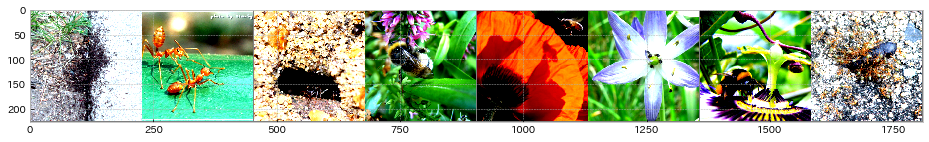

In [47]:
plt.figure(figsize=(16, 10))
imshow(torchvision.utils.make_grid(inputs))
print(" ".join([classes[x] for x in labels]))

In [49]:
outputs = model_ft(inputs)
_, preds = torch.max(outputs, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ant ant ant bee bee bee bee ant


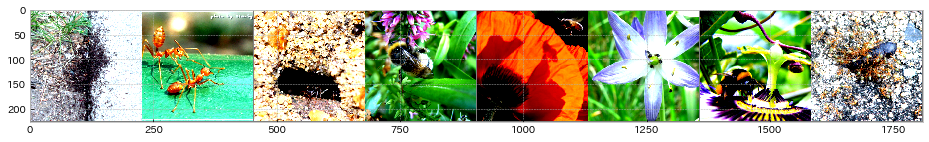

In [51]:
plt.figure(figsize=(16, 10))
imshow(torchvision.utils.make_grid(inputs))
print(" ".join([classes[x] for x in preds]))